In [1]:
import numpy as np
import pandas as pd

# For data analysis
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor

# Own functions
from functions.datacleaning import MoscowHousing as mh
from functions.distance import get_distance_coordinates, norm_features

# For extracting lat/long for Moscow metro
from selenium import webdriver
from selenium.webdriver.chrome.service import Service

# For handling extracted web data
from bs4 import BeautifulSoup
import re

# For visualization
import matplotlib.pylab as plt
import seaborn as sns
plt.style.use('ggplot')

# For testing
import unittest

Started with visualization of datapoints in both datasets (apartment and building joined) using online tool kepler.gl/demo. 

1. From the image three extreme outliers are identified. In training set: two, on St Johns and one near Vladivostok. In testing set: one in Kyrgistan, Bishkek (building id 4412).

2. Both training and test set has a bias of more apartments in the areas south east of central Moscow and a cluster in Zelenograd (north west). Inside the third circular road the distribution is more even.

3. The south east and  northern and eastern part of the center has lower prices than the western part. The total area of the apartments are also lower.

4. The inner central of Moscow have bigger appartments (total area) and higher prices.

5. Building id 4162 (training set) is missing district. Building id 1470 (test set) is closest to this building, and has district = 5. There are 130 units missing on this building (new in 2021). Suggest filling in 5 for missing values. Both of these buildings is very close to the third ring high way (radius around ring high ways? can be noisy?). Building id 1647 (testing set) is missing district, same lat/long as building id 4162 (training set). Set to district = 5?

6. Missing lat/long (test set) has address pos. Kommunarka, Moskva A101 (probalby wrong entry: can be close to noc Kommonarka 101, district=11, long:37.47376099999 lat 55.5608910000 building id 6200???), also missing district. Build in 2019, 12 stores, building id 3803, apartement id 23308 and 23375.


DATA PREPARATION (done)

All NaNs are treated as floats, so missing values for integers are replaced with -9, in order to keep the columns as type integers in pandas dataframes, and converted to NaN after csv import.


In [2]:
df_merged = pd.concat(map(pd.read_csv, ["../data/apartments_test.csv", "../data/apartments_train.csv"]), ignore_index=True)

In [3]:
dfTrain = pd.read_csv("../data/apartments_and_building_train.csv")

In [4]:
print(type(dfTrain["constructed"][0]))

<class 'numpy.int64'>


In [5]:
dfTrain.head()

,building_id,id,seller,price,area_total,price_per_square_meter,area_kitchen,area_living,floor,rooms,...,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,0,18450,-9,11300000.0,73.8,153116.531165,9.0,47.0,1,3,...,4АК3,-9,-9,5,-9,-9,-9,-9,-9,-9
1,1,20065,1,7100000.0,42.0,169047.619048,10.0,20.0,5,1,...,2305А,2015,2,17,0,1,1,1,1,0
2,2,2137,0,13600000.0,75.0,181333.333333,10.0,55.0,3,3,...,13,1987,3,12,0,1,0,1,1,0
3,3,4155,1,10100000.0,59.0,171186.440678,NaN,NaN,2,2,...,5К2,1996,2,7,0,1,1,-9,-9,0
4,3,8798,1,10100000.0,59.0,171186.440678,12.0,30.5,2,2,...,5К2,1996,2,7,0,1,1,-9,-9,0


In [6]:
dfTrain.describe()

,building_id,id,seller,price,area_total,price_per_square_meter,area_kitchen,area_living,floor,rooms,...,countpattern_street,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
count,23285.000000,23285.000000,23285.000000,2.328500e+04,23285.000000,2.328500e+04,18564.000000,19403.000000,23285.000000,23285.000000,...,23285.000000,23285.000000,23285.000000,23285.000000,23285.000000,23285.000000,23285.000000,23285.000000,23285.000000,23285.000000
mean,4844.089156,11642.000000,-2.248529,2.355617e+07,74.450999,2.478635e+05,12.552279,38.741367,8.969594,2.189349,...,0.005841,1934.131200,0.292764,17.608933,0.248615,0.777625,0.593730,-2.217994,-2.904316,-3.040026
std,2790.676698,6721.944845,5.346268,5.264393e+07,58.671373,1.701507e+05,6.565686,31.398480,8.322039,1.076130,...,0.076202,365.800556,4.315762,11.216638,1.251691,1.246134,1.273241,4.374996,4.766281,4.401886
min,0.000000,0.000000,-9.000000,9.000000e+05,9.300000,2.332361e+04,1.000000,0.000000,1.000000,1.000000,...,0.000000,-9.000000,-9.000000,1.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000
25%,2426.000000,5821.000000,-9.000000,7.490000e+06,42.000000,1.611111e+05,8.200000,20.000000,3.000000,1.000000,...,0.000000,1982.000000,0.000000,9.000000,0.000000,1.000000,0.000000,-9.000000,-9.000000,-9.000000
50%,4772.000000,11642.000000,1.000000,1.064500e+07,59.800000,1.973684e+05,10.700000,30.900000,7.000000,2.000000,...,0.000000,2012.000000,2.000000,16.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000
75%,7340.000000,17463.000000,3.000000,2.050000e+07,84.800000,2.680000e+05,15.300000,45.300000,12.000000,3.000000,...,0.000000,2019.000000,3.000000,22.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,9735.000000,23284.000000,3.000000,2.600000e+09,2181.000000,2.785756e+06,100.000000,900.000000,95.000000,6.000000,...,1.000000,2023.000000,6.000000,95.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000


In [7]:
dfTest = pd.read_csv("../data/apartments_and_building_test.csv")

In [8]:
dfTest.head()

,building_id,id,seller,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,...,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,4,26052,-9,395.0,NaN,NaN,3,6,-9,NaN,...,92,-9,-9,4,-9,-9,-9,-9,-9,-9
1,5,29404,1,24.6,2.0,20.0,1,1,-9,2.50,...,14К1,1982,3,12,0,1,0,-9,1,-9
2,6,24089,2,103.0,10.0,62.0,3,4,1,2.64,...,19,2002,3,22,0,1,1,1,1,0
3,11,24033,0,80.1,14.0,45.0,11,3,-9,NaN,...,52К1,2001,3,17,0,1,1,-9,1,0
4,11,32976,1,80.6,10.7,51.7,5,3,1,NaN,...,52К1,2001,3,17,0,1,1,-9,1,0


In [9]:
dfTest.describe()

,building_id,id,seller,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,...,district,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
count,9936.000000,9936.000000,9936.00000,9936.000000,7704.000000,7918.000000,9936.000000,9936.000000,9936.000000,4919.000000,...,9936.000000,9936.000000,9936.000000,9936.000000,9936.000000,9936.000000,9936.000000,9936.000000,9936.000000,9936.000000
mean,4694.816626,28253.245471,-2.48128,75.148732,12.874883,39.500515,9.184984,2.202999,-6.405093,3.725885,...,4.668076,1926.533313,0.348027,18.109098,0.258655,0.745773,0.570853,-2.199980,-2.601349,-2.830213
std,2772.584336,2868.749148,5.35378,56.360359,6.878015,33.145228,7.963050,1.107305,4.397768,15.915162,...,3.165385,383.512204,4.312509,10.724747,1.346593,1.345791,1.366215,4.357151,4.653748,4.302088
min,4.000000,23285.000000,-9.00000,13.000000,1.200000,0.000000,1.000000,1.000000,-9.000000,0.000000,...,0.000000,-9.000000,-9.000000,2.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000
25%,2145.000000,25768.750000,-9.00000,42.400000,8.200000,20.000000,3.000000,1.000000,-9.000000,2.650000,...,2.000000,1981.000000,0.000000,10.000000,0.000000,1.000000,0.000000,-9.000000,-9.000000,-9.000000
50%,4729.500000,28253.500000,1.00000,59.605000,10.800000,31.000000,7.000000,2.000000,-9.000000,2.800000,...,5.000000,2013.000000,2.000000,17.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000
75%,6983.250000,30737.250000,2.00000,86.000000,16.000000,45.400000,13.000000,3.000000,0.000000,3.000000,...,7.000000,2019.000000,3.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,9734.000000,33221.000000,3.00000,1175.000000,63.600000,528.000000,69.000000,6.000000,2.000000,350.000000,...,11.000000,2022.000000,6.000000,87.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000


In [10]:
dfAll = pd.concat(map(pd.read_csv, ["../data/apartments_and_building_train.csv", "../data/apartments_and_building_test.csv"]), ignore_index=True)

In [11]:
dfAll.describe()

,building_id,id,seller,price,area_total,price_per_square_meter,area_kitchen,area_living,floor,rooms,...,countpattern_street,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
count,33221.000000,33221.000000,33221.000000,2.328500e+04,33221.000000,2.328500e+04,26268.000000,27321.000000,33221.000000,33221.000000,...,23285.000000,33221.000000,33221.000000,33221.000000,33221.000000,33221.000000,33221.000000,33221.000000,33221.000000,33221.000000
mean,4799.443545,16610.222961,-2.318142,2.355617e+07,74.659683,2.478635e+05,12.646894,38.961378,9.034015,2.193432,...,0.005841,1931.858764,0.309292,17.758526,0.251618,0.768098,0.586888,-2.212606,-2.813702,-2.977273
std,2786.074557,9590.521069,5.349497,5.264393e+07,57.989866,1.701507e+05,6.660294,31.915799,8.216786,1.085549,...,0.076202,371.196990,4.314799,11.074017,1.280800,1.276819,1.301766,4.369609,4.734867,4.373267
min,0.000000,0.000000,-9.000000,9.000000e+05,9.300000,2.332361e+04,1.000000,0.000000,1.000000,1.000000,...,0.000000,-9.000000,-9.000000,1.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000
25%,2344.000000,8305.000000,-9.000000,7.490000e+06,42.000000,1.611111e+05,8.200000,20.000000,3.000000,1.000000,...,0.000000,1982.000000,0.000000,10.000000,0.000000,1.000000,0.000000,-9.000000,-9.000000,-9.000000
50%,4753.000000,16610.000000,1.000000,1.064500e+07,59.700000,1.973684e+05,10.700000,31.000000,7.000000,2.000000,...,0.000000,2012.000000,2.000000,16.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000
75%,7193.000000,24915.000000,3.000000,2.050000e+07,85.000000,2.680000e+05,15.600000,45.400000,12.000000,3.000000,...,0.000000,2019.000000,3.000000,22.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,9735.000000,33221.000000,3.000000,2.600000e+09,2181.000000,2.785756e+06,100.000000,900.000000,95.000000,6.000000,...,1.000000,2023.000000,6.000000,95.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000


[[<AxesSubplot:title={'center':'building_id'}>
  <AxesSubplot:title={'center':'id'}>
  <AxesSubplot:title={'center':'seller'}>
  <AxesSubplot:title={'center':'price'}>
  <AxesSubplot:title={'center':'area_total'}>
  <AxesSubplot:title={'center':'price_per_square_meter'}>]
 [<AxesSubplot:title={'center':'area_kitchen'}>
  <AxesSubplot:title={'center':'area_living'}>
  <AxesSubplot:title={'center':'floor'}>
  <AxesSubplot:title={'center':'rooms'}>
  <AxesSubplot:title={'center':'layout'}>
  <AxesSubplot:title={'center':'ceiling'}>]
 [<AxesSubplot:title={'center':'bathrooms_shared'}>
  <AxesSubplot:title={'center':'bathrooms_private'}>
  <AxesSubplot:title={'center':'windows_court'}>
  <AxesSubplot:title={'center':'windows_street'}>
  <AxesSubplot:title={'center':'balconies'}>
  <AxesSubplot:title={'center':'loggias'}>]
 [<AxesSubplot:title={'center':'condition'}>
  <AxesSubplot:title={'center':'phones'}>
  <AxesSubplot:title={'center':'new'}>
  <AxesSubplot:title={'center':'latitude'}>
 

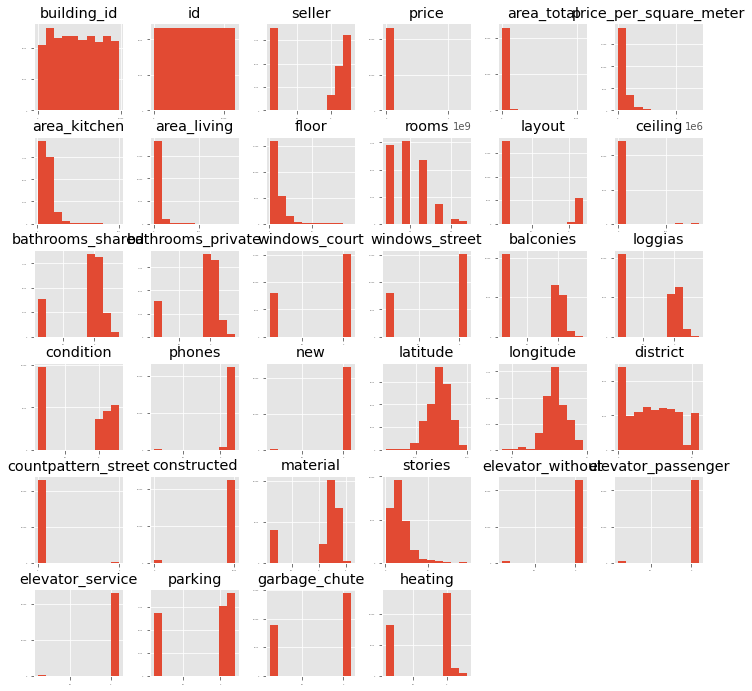

In [12]:
print(dfTrain.hist(xlabelsize=2, ylabelsize=2, figsize=(12,12)))

[[<AxesSubplot:title={'center':'building_id'}>
  <AxesSubplot:title={'center':'id'}>
  <AxesSubplot:title={'center':'seller'}>
  <AxesSubplot:title={'center':'area_total'}>
  <AxesSubplot:title={'center':'area_kitchen'}>
  <AxesSubplot:title={'center':'area_living'}>]
 [<AxesSubplot:title={'center':'floor'}>
  <AxesSubplot:title={'center':'rooms'}>
  <AxesSubplot:title={'center':'layout'}>
  <AxesSubplot:title={'center':'ceiling'}>
  <AxesSubplot:title={'center':'bathrooms_shared'}>
  <AxesSubplot:title={'center':'bathrooms_private'}>]
 [<AxesSubplot:title={'center':'windows_court'}>
  <AxesSubplot:title={'center':'windows_street'}>
  <AxesSubplot:title={'center':'balconies'}>
  <AxesSubplot:title={'center':'loggias'}>
  <AxesSubplot:title={'center':'condition'}>
  <AxesSubplot:title={'center':'phones'}>]
 [<AxesSubplot:title={'center':'new'}>
  <AxesSubplot:title={'center':'latitude'}>
  <AxesSubplot:title={'center':'longitude'}>
  <AxesSubplot:title={'center':'district'}>
  <AxesSubp

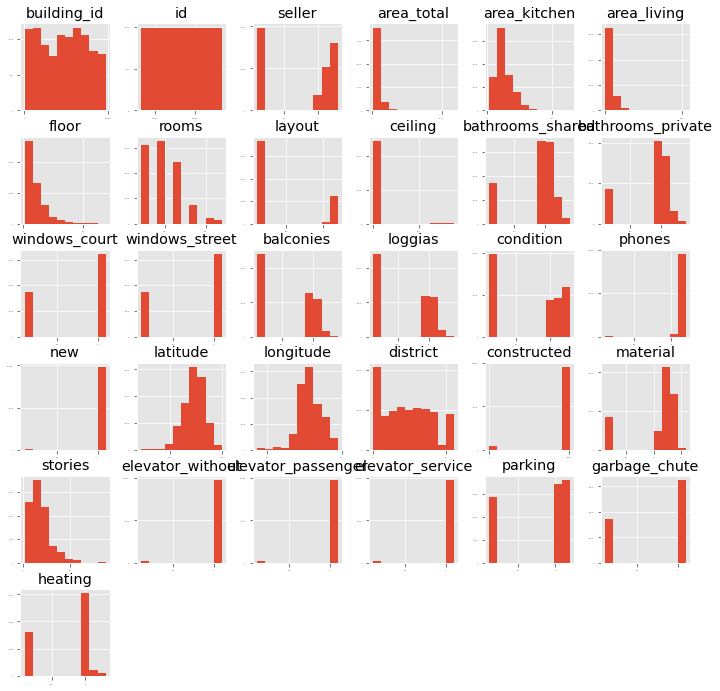

In [13]:
print(dfTest.hist(xlabelsize=2, ylabelsize=2, figsize=(12,12)))

[[<AxesSubplot:title={'center':'building_id'}>
  <AxesSubplot:title={'center':'id'}>
  <AxesSubplot:title={'center':'seller'}>
  <AxesSubplot:title={'center':'price'}>
  <AxesSubplot:title={'center':'area_total'}>
  <AxesSubplot:title={'center':'price_per_square_meter'}>]
 [<AxesSubplot:title={'center':'area_kitchen'}>
  <AxesSubplot:title={'center':'area_living'}>
  <AxesSubplot:title={'center':'floor'}>
  <AxesSubplot:title={'center':'rooms'}>
  <AxesSubplot:title={'center':'layout'}>
  <AxesSubplot:title={'center':'ceiling'}>]
 [<AxesSubplot:title={'center':'bathrooms_shared'}>
  <AxesSubplot:title={'center':'bathrooms_private'}>
  <AxesSubplot:title={'center':'windows_court'}>
  <AxesSubplot:title={'center':'windows_street'}>
  <AxesSubplot:title={'center':'balconies'}>
  <AxesSubplot:title={'center':'loggias'}>]
 [<AxesSubplot:title={'center':'condition'}>
  <AxesSubplot:title={'center':'phones'}>
  <AxesSubplot:title={'center':'new'}>
  <AxesSubplot:title={'center':'latitude'}>
 

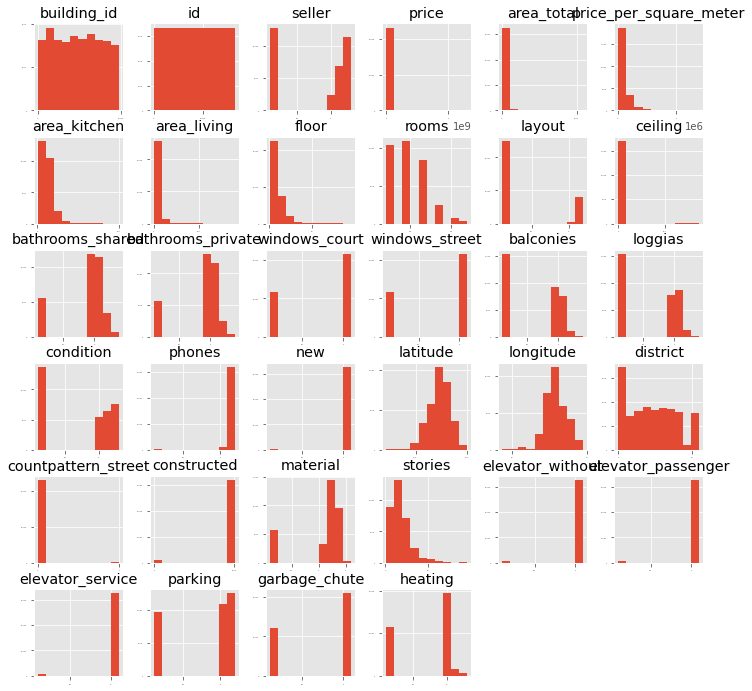

In [14]:
print(dfAll.hist(xlabelsize=2, ylabelsize=2, figsize=(12,12)))

<AxesSubplot:xlabel='district', ylabel='price'>

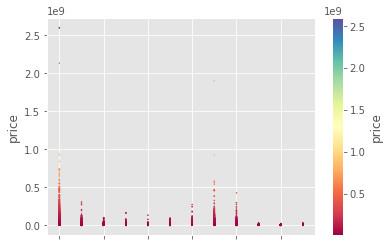

In [15]:
dfTrain.plot.scatter("district", "price", s=1, c="price", colormap="Spectral")

<AxesSubplot:xlabel='district', ylabel='area_total'>

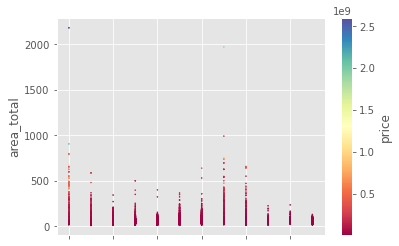

In [16]:
dfTrain.plot.scatter("district", "area_total", s=1, c="price", colormap="Spectral")

<AxesSubplot:xlabel='condition', ylabel='price'>

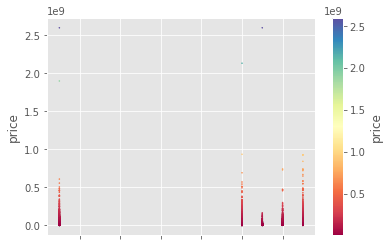

In [17]:
dfTrain.plot.scatter("condition", "price", s=1, c="price", colormap="Spectral")

<AxesSubplot:xlabel='elevator_without', ylabel='stories'>

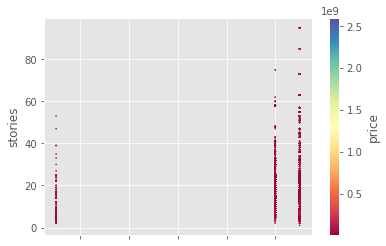

In [18]:
dfTrain.plot.scatter("elevator_without", "stories", s=1, c="price", colormap="Spectral")

<AxesSubplot:xlabel='latitude', ylabel='longitude'>

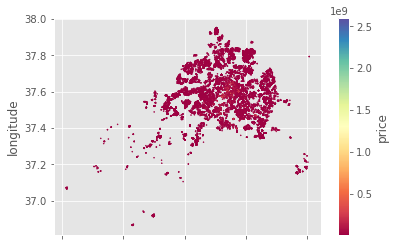

In [19]:
# Unadjusted plotting of lat and long with price as graded colors
dfTrain.plot.scatter("latitude", "longitude", s=1, c="price", colormap="Spectral")

<AxesSubplot:xlabel='latitude', ylabel='longitude'>

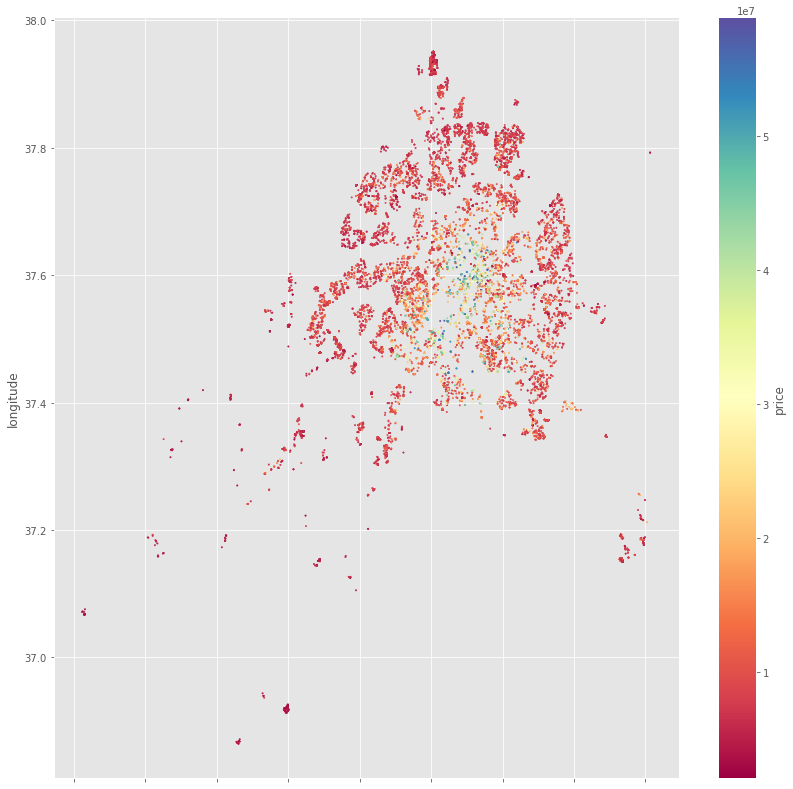

In [20]:
# Filtering out outliers (select quantile size)
df = dfTrain.copy()
qhigh = df["price"].quantile(0.92)
qlow  = df["price"].quantile(0.0005)
df = df[(df["price"] < qhigh) & (df["price"] > qlow)]
df.plot.scatter("latitude", "longitude", s=2, c="price", colormap="Spectral", figsize=(14,14))

<AxesSubplot:xlabel='latitude', ylabel='longitude'>

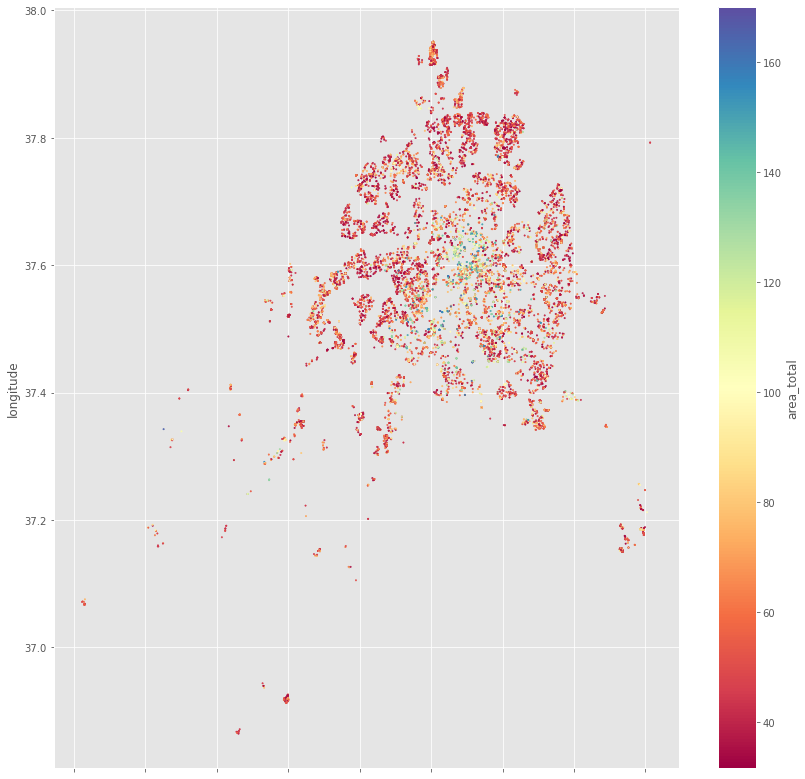

In [21]:
# Plotting apartments total area
df = dfTrain.copy()
qhigh = df["area_total"].quantile(0.95)
qlow  = df["area_total"].quantile(0.05)
df = df[(df["area_total"] < qhigh) & (df["area_total"] > qlow)]
df.plot.scatter("latitude", "longitude", s=2, c="area_total", colormap="Spectral", figsize=(14,14))

<AxesSubplot:xlabel='latitude', ylabel='longitude'>

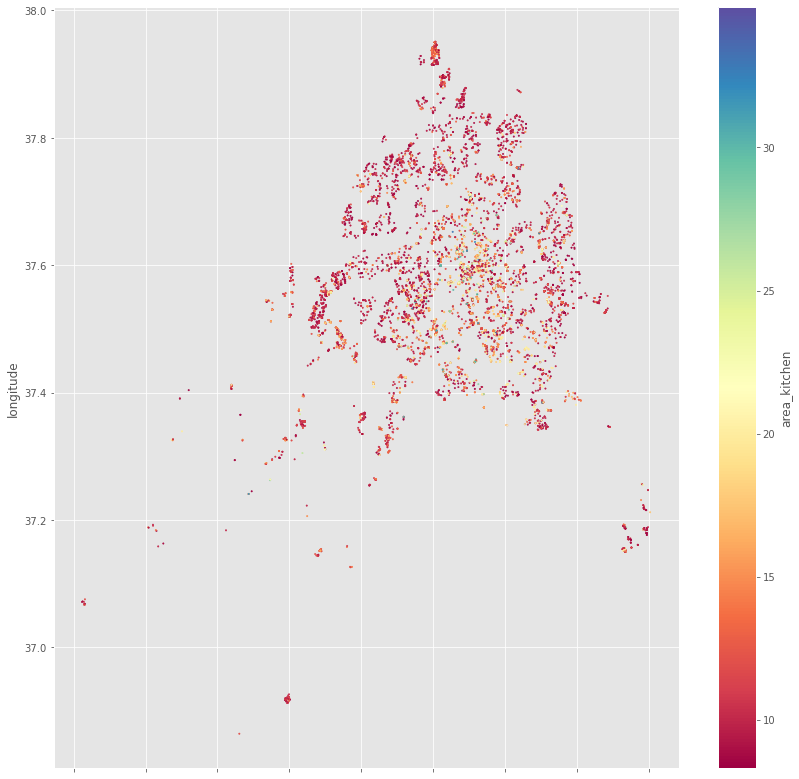

In [22]:
df = dfTrain.copy()
qhigh = df["area_kitchen"].quantile(0.99)
qlow  = df["area_kitchen"].quantile(0.25)
df = df[(df["area_kitchen"] < qhigh) & (df["area_kitchen"] > qlow)]
df.plot.scatter("latitude", "longitude", s=2, c="area_kitchen", colormap="Spectral", figsize=(14,14))

<AxesSubplot:xlabel='area_total', ylabel='price'>

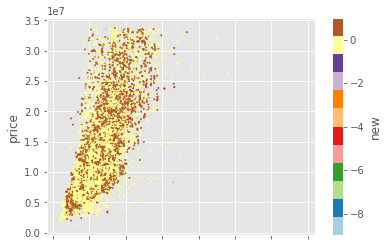

In [23]:
# Plot area by price coloring new = yellow, not new = brown
df = dfTrain.copy()
qhigh = df["price"].quantile(0.85)
qlow  = df["price"].quantile(0.0001)
df = df[(df["price"] < qhigh) & (df["price"] > qlow)]
df.plot.scatter("area_total", "price", s=2, c="new", colormap="Paired")

<AxesSubplot:xlabel='rooms', ylabel='price'>

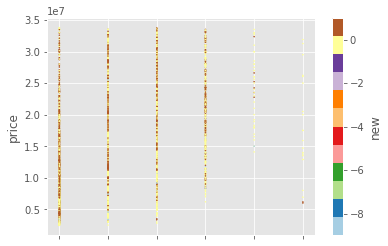

In [24]:
df = dfTrain.copy()
qhigh = df["price"].quantile(0.85)
qlow  = df["price"].quantile(0.001)
df = df[(df["price"] < qhigh) & (df["price"] > qlow)]
df.plot.scatter("rooms", "price", s=1, c="new", colormap="Paired")

In [25]:
df = dfTrain.copy()
qhigh = df["price"].quantile(0.92)
qlow  = df["price"].quantile(0.005)
df = df[(df["price"] < qhigh) & (df["price"] > qlow)]
y = df["price"].copy()
X = df["area_total"].copy()
X_train = X[:10000]
y_train = y[:10000]
X_test  = X[10000:]
y_test  = y[10000:]
reg_model = LinearRegression()

In [26]:
# print(X_train)

In [27]:
# print(y_train)

In [28]:
reg_model.fit(X_train.values.reshape(-1, 1), y_train.values.reshape(-1, 1))

LinearRegression()

In [29]:
y_pred = reg_model.predict(X_test.values.reshape(-1, 1))

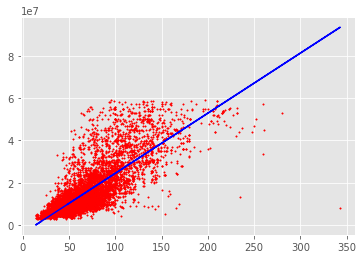

In [30]:
plt.scatter(X_test, y_test, s=2, color = 'red')
plt.plot(X_test, reg_model.predict(X_test.values.reshape(-1, 1)), color = 'blue')

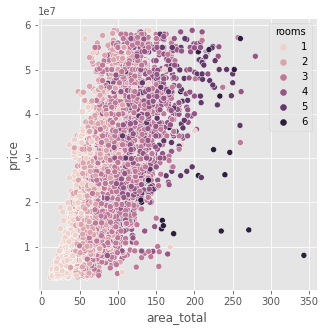

In [31]:
df = dfTrain.copy()
qhigh = df["price"].quantile(0.92)
qlow  = df["price"].quantile(0.005)
df = df[(df["price"] < qhigh) & (df["price"] > qlow)]
y = df["price"].copy()
X = df["area_total"].copy()
plt.figure(figsize=(5, 5))
sns.scatterplot(x="area_total", y="price", hue='rooms', data=df);

In [32]:
import math  # degrees to radians

# The Haversine formula
# https://en.wikipedia.org/wiki/Haversine_formula
def get_distance(lat1, lon1, lat2=55.751244, lon2=37.618423):
    R = 6371 # Approximate radius of earth in km
    # Use radians
    rlat1 = math.radians(lat1)
    rlat2 = math.radians(lat2)
    rlon1 = math.radians(lon1)
    rlon2 = math.radians(lon2)
    dLat = rlat2 - rlat1
    dLon = rlon2 - rlon1
    a = (np.sin(dLat/2) * np.sin(dLat/2) + np.cos(rlat1) * 
         np.cos(rlat2) * np.sin(dLon/2) * np.sin(dLon/2)
         )
    c = 2 * math.atan2(np.sqrt(a), np.sqrt(1-a))
    d = R * c
    return d

data_dist = dfTrain.copy()
data_dist.head()

,building_id,id,seller,price,area_total,price_per_square_meter,area_kitchen,area_living,floor,rooms,...,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,0,18450,-9,11300000.0,73.8,153116.531165,9.0,47.0,1,3,...,4АК3,-9,-9,5,-9,-9,-9,-9,-9,-9
1,1,20065,1,7100000.0,42.0,169047.619048,10.0,20.0,5,1,...,2305А,2015,2,17,0,1,1,1,1,0
2,2,2137,0,13600000.0,75.0,181333.333333,10.0,55.0,3,3,...,13,1987,3,12,0,1,0,1,1,0
3,3,4155,1,10100000.0,59.0,171186.440678,NaN,NaN,2,2,...,5К2,1996,2,7,0,1,1,-9,-9,0
4,3,8798,1,10100000.0,59.0,171186.440678,12.0,30.5,2,2,...,5К2,1996,2,7,0,1,1,-9,-9,0


In [33]:
data_dist["distance"] = data_dist.loc[:, "latitude":"longitude"].apply(lambda x: get_distance(x.latitude, x.longitude), axis=1)

In [34]:
data_dist["distance"].head()

0    10.252880
1    36.091930
2    12.374064
3    15.232969
4    15.232969
Name: distance, dtype: float64

In [35]:
data_dist.head()

,building_id,id,seller,price,area_total,price_per_square_meter,area_kitchen,area_living,floor,rooms,...,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating,distance
0,0,18450,-9,11300000.0,73.8,153116.531165,9.0,47.0,1,3,...,-9,-9,5,-9,-9,-9,-9,-9,-9,10.252880
1,1,20065,1,7100000.0,42.0,169047.619048,10.0,20.0,5,1,...,2015,2,17,0,1,1,1,1,0,36.091930
2,2,2137,0,13600000.0,75.0,181333.333333,10.0,55.0,3,3,...,1987,3,12,0,1,0,1,1,0,12.374064
3,3,4155,1,10100000.0,59.0,171186.440678,NaN,NaN,2,2,...,1996,2,7,0,1,1,-9,-9,0,15.232969
4,3,8798,1,10100000.0,59.0,171186.440678,12.0,30.5,2,2,...,1996,2,7,0,1,1,-9,-9,0,15.232969


<AxesSubplot:xlabel='area_total', ylabel='price'>

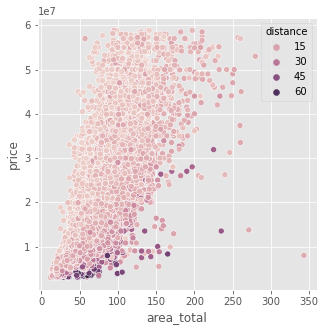

In [36]:
df = data_dist.copy()
qhigh = df["price"].quantile(0.92)
qlow  = df["price"].quantile(0.005)
df = df[(df["price"] < qhigh) & (df["price"] > qlow)]
y = df["price"].copy()
X = df["area_total"].copy()
plt.figure(figsize=(5, 5))
sns.scatterplot(x="area_total", y="price", hue='distance', data=df)

<AxesSubplot:xlabel='area_total', ylabel='distance'>

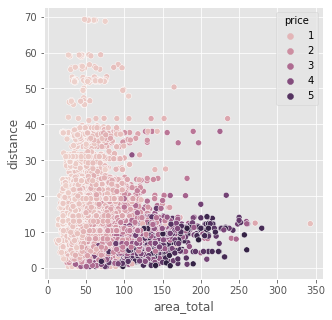

In [37]:
df = data_dist.copy()
qhigh = df["price"].quantile(0.92)
qlow  = df["price"].quantile(0.005)
df = df[(df["price"] < qhigh) & (df["price"] > qlow)]
y = df["price"].copy()
X = df["area_total"].copy()
plt.figure(figsize=(5, 5))
sns.scatterplot(x="area_total", y="distance", hue='price', data=df)

In [38]:
# Calculate z-scores

def z_score(X):
    return (X - X.mean())/X.std(ddof=0)

In [39]:
df = data_dist.copy()
qhigh = df["price"].quantile(0.92)
qlow  = df["price"].quantile(0.005)
df = df[(df["price"] < qhigh) & (df["price"] > qlow)]

In [40]:
df["price_z"] = z_score(df["price"])

<AxesSubplot:xlabel='price', ylabel='distance'>

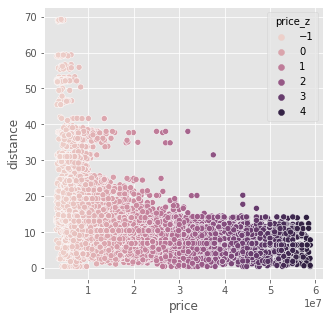

In [41]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x="price", y="distance", hue='price_z', data=df)

In [42]:
df["price_sq_meter"] = df["price"]/df["area_total"]

<AxesSubplot:xlabel='price_sq_meter', ylabel='distance'>

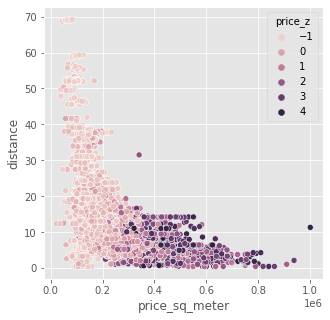

In [43]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x="price_sq_meter", y="distance", hue='price_z', data=df)

<AxesSubplot:xlabel='constructed', ylabel='distance'>

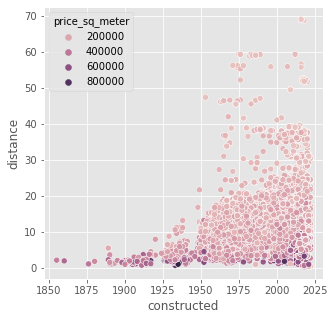

In [44]:
qhigh_c = df["constructed"].quantile(1.0)
qlow_c  = df["constructed"].quantile(0.005)
df = df[(df["constructed"] < qhigh_c) & (df["constructed"] > qlow_c)]

plt.figure(figsize=(5, 5))
sns.scatterplot(x="constructed", y="distance", hue='price_sq_meter', data=df)

<AxesSubplot:xlabel='constructed', ylabel='district'>

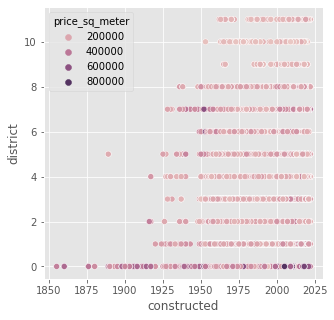

In [45]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x="constructed", y="district", hue='price_sq_meter', data=df)

# Using normalized prepared data (distance + distance_metro)

In [46]:
df = pd.read_csv("../prepared_data/test_prepared.csv")

In [47]:
df.shape

(9937, 35)

In [48]:
data = mh(
          coordinates=None,
          data_train="../prepared_data/train_prepared.csv",
          data_test="../prepared_data/test_prepared.csv",
          need_correction=False,
          normalize = True,
          features_float = ["area_total", 
                            "distance", 
                            "area_kitchen", 
                            "area_living", 
                            "ceiling",
                            "distance_metro"]
          )

In [49]:
XTrain, YTrain = data.get_data_train()
XTest = data.get_data_test()

In [50]:
X_Train = XTrain.copy()
Y_Train = YTrain.copy()
X_Test = XTest.copy()

In [51]:
X_Train.head()

,building_id,id,seller,price,area_total,price_per_square_meter,area_kitchen,area_living,floor,rooms,...,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating,distance,distance_metro
0,0,18450,NaN,11300000.0,-0.011096,153116.531165,-0.541037,0.263027,1,3,...,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,-0.315749,-0.385108
1,1,20065,1.0,7100000.0,-0.553098,169047.619048,-0.388730,-0.596888,5,1,...,2.0,17,0.0,1.0,1.0,1.0,1.0,0.0,2.903551,4.059285
2,2,2137,0.0,13600000.0,0.009357,181333.333333,-0.388730,0.517816,3,3,...,3.0,12,0.0,1.0,0.0,1.0,1.0,0.0,-0.051469,-0.197800
3,3,4155,1.0,10100000.0,-0.263348,171186.440678,NaN,NaN,2,2,...,2.0,7,0.0,1.0,1.0,NaN,NaN,0.0,0.304723,-0.072338
4,3,8798,1.0,10100000.0,-0.263348,171186.440678,-0.084116,-0.262477,2,2,...,2.0,7,0.0,1.0,1.0,NaN,NaN,0.0,0.304723,-0.072338


In [52]:
Y_Train.head()

0   -0.232813
1   -0.312594
2   -0.189123
3   -0.255607
4   -0.255607
Name: price, dtype: float64

In [53]:
X_Test.head()

,building_id,id,seller,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,...,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating,distance,distance_metro
0,4,26052,NaN,5.675295,NaN,NaN,3,6,NaN,NaN,...,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,0.293752,0.100256
1,5,29404,1.0,-0.896821,-1.581108,-0.588336,1,1,NaN,-0.077026,...,3.0,12,0.0,1.0,0.0,NaN,1.0,NaN,0.116589,-0.049463
2,6,24089,2.0,0.494253,-0.417982,0.678815,3,4,1.0,-0.068230,...,3.0,22,0.0,1.0,1.0,1.0,1.0,0.0,-0.040901,-0.028613
3,11,24033,0.0,0.087932,0.163582,0.165921,11,3,NaN,NaN,...,3.0,17,0.0,1.0,1.0,NaN,1.0,0.0,0.074818,-0.034223
4,11,32976,1.0,0.096804,-0.316208,0.368062,5,3,1.0,NaN,...,3.0,17,0.0,1.0,1.0,NaN,1.0,0.0,0.074818,-0.034223


In [ ]:
X = X_Train.copy()
y = Y_Train.copy()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)